<a href="https://colab.research.google.com/github/SiPilip/diabetes-counter-propogation-network/blob/main/diabetes_using_cpn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [203]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [204]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
df = pd.read_csv("/content/diabetes.csv")

In [206]:
# Ganti 0 dengan NaN
# Kolom yang tidak boleh bernilai 0
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[invalid_zero_cols] = df[invalid_zero_cols].replace(0, pd.NA)

# 2. Tampilkan ringkasan awal
print("Jumlah data awal:", df.shape)
print("\nJumlah missing value per kolom:\n", df.isnull().sum())

df.head()

Jumlah data awal: (100, 9)

Jumlah missing value per kolom:
 Pregnancies                  0
Glucose                      1
BloodPressure                6
SkinThickness               32
Insulin                     55
BMI                          4
DiabetesPedigreeFunction     0
Age                          0
Outcome                      0
dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,<NA>,33.6,0.627,50,1
1,1,85,66,29,<NA>,26.6,0.351,31,0
2,8,183,64,<NA>,<NA>,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [207]:
# Imputasi nilai NaN dengan median kolom masing-masing
for col in invalid_zero_cols:
    df[col] = df[col].fillna(df[col].median())

# Simpan DataFrame hasil preprocessing ke file CSV
df.to_csv("preprocessed_data_before_normalization.csv", index=False)

# (Opsional) Pisahkan fitur dan target
X = df.drop(columns='Outcome')
y = df['Outcome']

df.to_csv("preprocessed_data_after_normalization.csv", index=False)

# Tampilkan hasil akhir
print(X.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0    125.0  33.6   
1            1     85.0           66.0           29.0    125.0  26.6   
2            8    183.0           64.0           29.0    125.0  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     2.288   33  


<ipython-input-207-b880f39c9ba6>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].median())
<ipython-input-207-b880f39c9ba6>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].median())
<ipython-input-207-b880f39c9ba6>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] 

In [208]:
# Spliting data

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X
y_train = y

X_test = X
y_test = y

In [209]:
# Konversi fitur (X) dari DataFrame ke Tensor
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)

# Konversi label (y) dari Series ke Tensor
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

# Jika label dalam bentuk one-hot, ubah ke index kelas
if y_train.ndim == 2:
    y_train = torch.argmax(y_train, dim=1)
if y_test.ndim == 2:
    y_test = torch.argmax(y_test, dim=1)

# Pastikan tipe data label adalah long (untuk CrossEntropyLoss)
y_train = y_train.long()
y_test = y_test.long()


### Counter Propagation Network --> CPN

In [210]:
from torch import nn
import torch.nn.functional as F

In [211]:
import torch
from torch import nn

class CPN(nn.Module):
    def __init__(self, input_size: int, kohonen_size: int, output_size: int):
        super(CPN, self).__init__()
        # Kohonen layer (unsupervised)
        self.kohonen = nn.Linear(input_size, kohonen_size, bias=False)

        # Grossberg layer (supervised)
        self.grossberg = nn.Linear(kohonen_size, output_size)

    def forward(self, x):
        # Kohonen layer - winner takes all (argmax activation)
        kohonen_output = self.kohonen(x)
        winner_index = torch.argmax(kohonen_output, dim=1)
        one_hot_output = torch.zeros_like(kohonen_output)
        one_hot_output[torch.arange(x.size(0)), winner_index] = 1.0

        # Grossberg layer - supervised output
        output = self.grossberg(one_hot_output)
        return output

In [212]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CPN(input_size=X_train.shape[1], kohonen_size=10, output_size=len(torch.unique(y_train)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [213]:
print("Bobot awal Kohonen:\n", model.kohonen.weight.data)
print("Bobot awal Grossberg:\n", model.grossberg.weight.data)

Bobot awal Kohonen:
 tensor([[ 0.0044,  0.1902,  0.2261,  0.1889, -0.1410,  0.2848, -0.3208, -0.0447],
        [-0.2228, -0.0885, -0.0875,  0.0708, -0.0358,  0.1202, -0.2973, -0.2364],
        [-0.2505, -0.1218, -0.0387,  0.0301,  0.1767, -0.1035,  0.0073,  0.2606],
        [-0.0044, -0.0724, -0.1021, -0.2235,  0.3342,  0.0061,  0.1726, -0.0340],
        [-0.0471,  0.2629,  0.0614, -0.3381, -0.2436, -0.3112, -0.0927,  0.2503],
        [-0.2121, -0.0637,  0.1867, -0.1724, -0.0211, -0.1214, -0.1601, -0.2765],
        [ 0.3290, -0.2703, -0.0068, -0.2688,  0.0272, -0.2900, -0.2255, -0.1466],
        [-0.3023, -0.3100, -0.2523,  0.2052,  0.0710, -0.1804,  0.0601,  0.1819],
        [ 0.0180, -0.1782, -0.3286,  0.2078, -0.1500, -0.0043,  0.3147,  0.1293],
        [-0.3475, -0.1112,  0.0131, -0.0380, -0.0387,  0.0250,  0.1394, -0.2420]])
Bobot awal Grossberg:
 tensor([[-0.2325, -0.1848,  0.3082, -0.2416, -0.2396,  0.0344,  0.2302, -0.0792,
         -0.1162,  0.1197],
        [-0.2223,  0.2307,

In [214]:
print(X_train.shape[1])

8


In [215]:
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               device: torch.device,
               epoch: int,
               alpha: float = 1e-2,
               error_threshold: float = 1e-3) -> float:
    model.train()
    train_acc = 0
    manual_results = []

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            for i in range(X.size(0)):  # proses tiap sampel (karena CPN tidak pakai batch update)
                sample_X = X[i].unsqueeze(0)  # bentuk (1, input_dim)
                sample_y = y[i].item()

                # Forward Kohonen
                kohonen_output = model.kohonen(sample_X)
                winner_index = torch.argmax(kohonen_output, dim=1).item()
                z = torch.zeros_like(kohonen_output)
                z[0, winner_index] = 1.0

                # Forward Grossberg
                grossberg_output = model.grossberg(z)
                pred_y = torch.argmax(grossberg_output, dim=1).item()

                # Hitung error
                y_true_onehot = torch.zeros(1, grossberg_output.shape[1], device=device)
                y_true_onehot[0, sample_y] = 1
                error = grossberg_output - y_true_onehot

                # Simpan bobot sebelum update
                W_before = model.grossberg.weight.data.clone().detach().cpu()

                # Update Grossberg jika error cukup besar
                delta_W = -alpha * z.T @ error
                if torch.abs(error).max() >= error_threshold:
                    model.grossberg.weight.data += delta_W.T
                    W_after = W_before + delta_W.T.cpu()
                else:
                    W_after = W_before  # Tidak berubah jika error kecil

                # Akumulasi akurasi
                train_acc += int(pred_y == sample_y)

                # Simpan hasil manual
                result = {
                    "epoch": epoch + 1,
                    **{f"x{j+1}": sample_X[0][j].item() for j in range(sample_X.shape[1])},
                    "y_true": sample_y,
                    "y_pred": pred_y,
                }

                for j in range(grossberg_output.shape[1]):
                    result[f"error_{j}"] = error[0][j].item()
                for j in range(grossberg_output.shape[1]):
                    for k in range(z.shape[1]):
                        result[f"w{j}_{k}_after"] = W_after[j][k].item()
                        result[f"delta_w{j}_{k}"] = delta_W.T[j][k].item()

                manual_results.append(result)

    # Simpan ke CSV
    csv_path = "manual_cpn_forward_backward.csv"
    write_header = not os.path.exists(csv_path)

    if manual_results:
        with open(csv_path, mode='a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=manual_results[0].keys())
            if write_header:
                writer.writeheader()
            writer.writerows(manual_results)

    train_acc /= len(dataloader.dataset)
    return train_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          epochs: int,
          device: torch.device,
          alpha: float = 1e-2,
          error_threshold: float = 1e-3) -> Dict[str, List]:

    results = {"train_acc": []}
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_acc = train_step(model=model,
                               dataloader=train_dataloader,
                               device=device,
                               epoch=epoch,
                               alpha=alpha,
                               error_threshold=error_threshold)

        print(f"Epoch: {epoch+1} | train_acc: {train_acc:.4f}")
        results["train_acc"].append(train_acc)

    return results


In [216]:
results = train(
    model=model,
    train_dataloader=train_dataloader,
    epochs=5,
    device=device,
    alpha=0.01,
    error_threshold=1e-3
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_acc: 0.4800
Epoch: 2 | train_acc: 0.6300
Epoch: 3 | train_acc: 0.6300
Epoch: 4 | train_acc: 0.6300
Epoch: 5 | train_acc: 0.6300


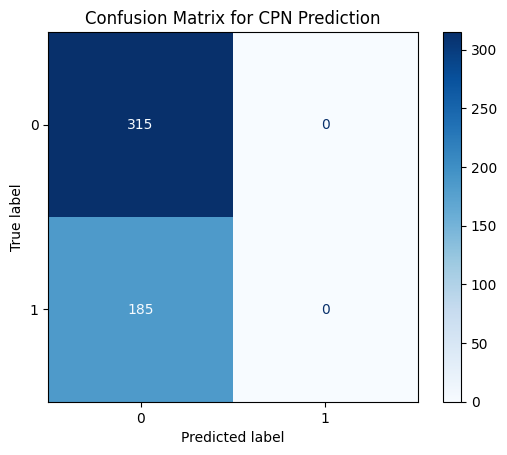

In [222]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ambil data dari CSV hasil manual forward-backward
df = pd.read_csv("manual_cpn_forward_backward (11).csv")
y_true = df["y_true"]
y_pred = df["y_pred"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for CPN Prediction")
plt.show()


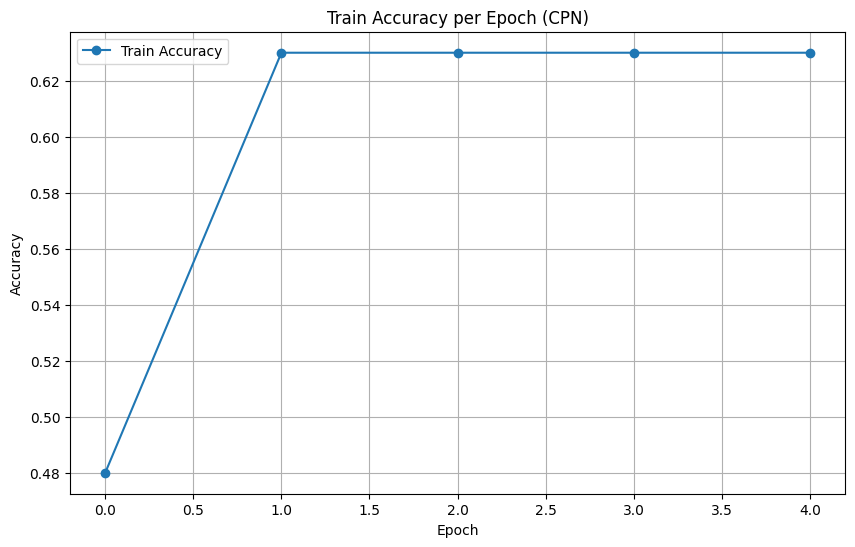

In [218]:
model_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(range(len(model_df)), model_df["train_acc"], label="Train Accuracy", marker='o')
plt.title("Train Accuracy per Epoch (CPN)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()